In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noshowappointments/KaggleV2-May-2016.csv
/kaggle/input/hellodata/KaggleV2-May-2016.csv


Epoch 0, Loss: 0.1635
Epoch 10, Loss: 0.1627
Epoch 20, Loss: 0.1623
Epoch 30, Loss: 0.1620
Epoch 40, Loss: 0.1618
Epoch 50, Loss: 0.1617
Epoch 60, Loss: 0.1615
Epoch 70, Loss: 0.1613
Epoch 80, Loss: 0.1612
Epoch 90, Loss: 0.1610
Epoch 100, Loss: 0.1609
Epoch 110, Loss: 0.1608
Epoch 120, Loss: 0.1606
Epoch 130, Loss: 0.1605
Epoch 140, Loss: 0.1604
Training Time: 10.40 seconds
Best Threshold: 0.16, Best F1 Score: 0.3406
Accuracy: 0.3067
F1 Score: 0.3406
PR-AUC: 0.2328
Confusion Matrix:
 [[ 2823 14846]
 [  479  3958]]


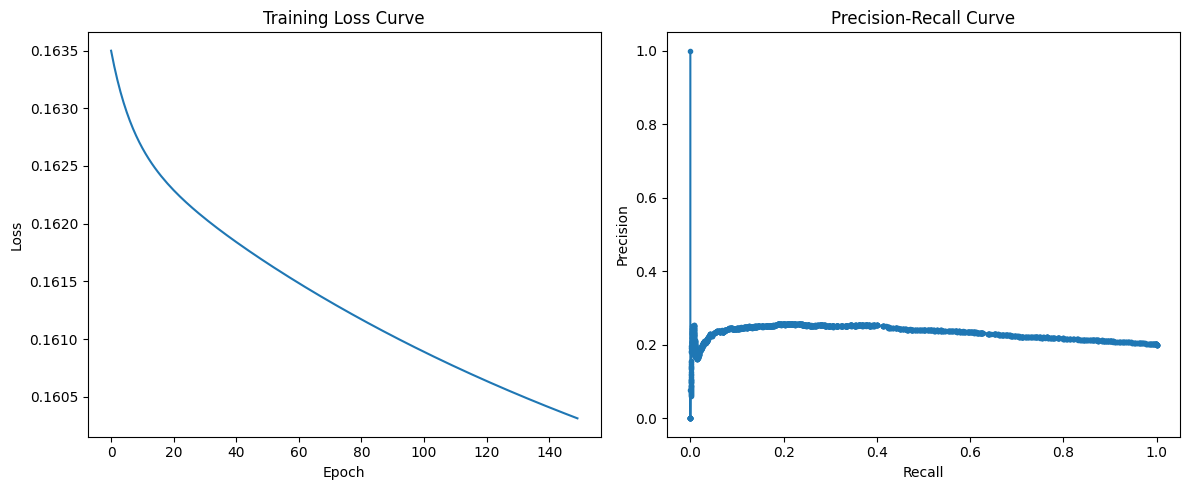

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_curve,
    auc, confusion_matrix
)
import matplotlib.pyplot as plt
import time


# Load dataset
df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood'], axis=1, inplace=True)

# Encode categorical variables
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})

# Features and target
X = df.drop('No-show', axis=1).values
y = df['No-show'].values

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Xavier Initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_deriv(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output, lr):
        m = y.shape[0]
        y = y.reshape(-1, 1)

        dz2 = output - y
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_deriv(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def train(self, X, y, epochs=100, lr=0.1):
        losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            loss = np.mean((y.reshape(-1, 1) - output) ** 2)
            losses.append(loss)
            self.backward(X, y, output, lr)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

start_time = time.time()

model = NeuralNetwork(input_size=X.shape[1], hidden_size=32, output_size=1)
losses = model.train(X_train, y_train, epochs=150, lr=0.05)

train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")

y_pred_probs = model.forward(X_val).flatten()

best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_probs > thresh).astype(int)
    score = f1_score(y_val, y_pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.2f}, Best F1 Score: {best_f1:.4f}")



y_pred_final = (y_pred_probs > best_thresh).astype(int)

acc = accuracy_score(y_val, y_pred_final)
f1 = f1_score(y_val, y_pred_final)
precision, recall, _ = precision_recall_curve(y_val, y_pred_probs)
pr_auc = auc(recall, precision)
cm = confusion_matrix(y_val, y_pred_final)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:\n", cm)



plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.5912
Epoch 10, Loss: 0.4983
Epoch 20, Loss: 0.4953
Epoch 30, Loss: 0.4940
Epoch 40, Loss: 0.4925
Epoch 50, Loss: 0.4921
Epoch 60, Loss: 0.4919
Epoch 70, Loss: 0.4918
Epoch 80, Loss: 0.4916
Epoch 90, Loss: 0.4915
Epoch 100, Loss: 0.4915
Epoch 110, Loss: 0.4914
Epoch 120, Loss: 0.4913
Epoch 130, Loss: 0.4913
Epoch 140, Loss: 0.4912
Training Time: 2.13 seconds
Best Threshold: 0.17, Best F1 Score: 0.3498
Accuracy: 0.4550
F1 Score: 0.3498
PR-AUC: 0.2724
Confusion Matrix:
 [[ 6817 10852]
 [ 1196  3241]]


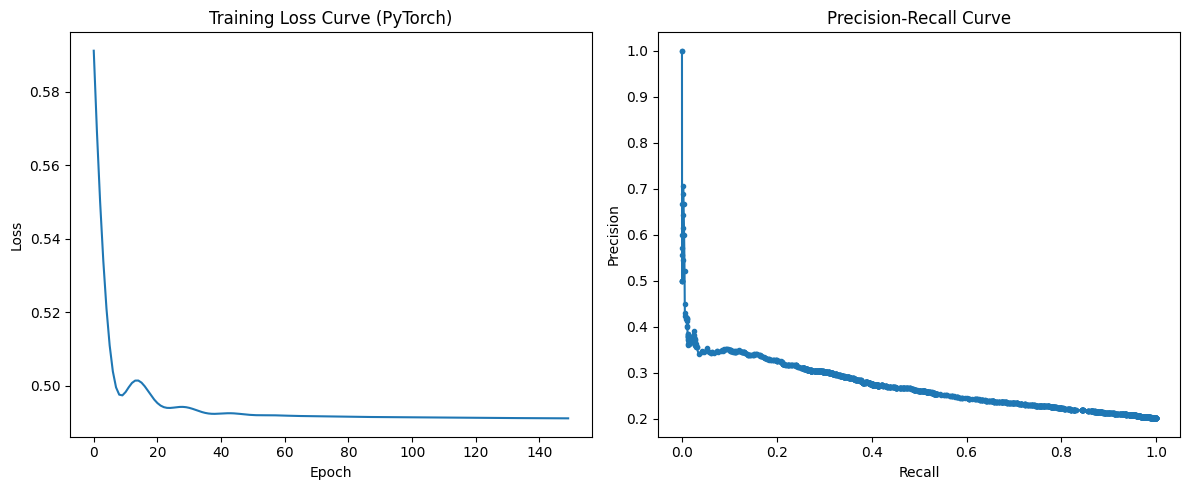

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_curve,
    auc, confusion_matrix
)
import matplotlib.pyplot as plt
import time



df = pd.read_csv('/kaggle/input/noshowappointments/KaggleV2-May-2016.csv')
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood'], axis=1, inplace=True)

# Encode
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})

# Features and target
X = df.drop('No-show', axis=1).values
y = df['No-show'].values

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)



class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = NeuralNet(input_size=X.shape[1], hidden_size=32)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



losses = []
start_time = time.time()

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")


model.eval()
with torch.no_grad():
    y_pred_probs = model(X_val_tensor).numpy().flatten()

# Threshold tuning for best F1
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_pred_probs > thresh).astype(int)
    score = f1_score(y_val, y_pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.2f}, Best F1 Score: {best_f1:.4f}")

# Final prediction
y_pred_final = (y_pred_probs > best_thresh).astype(int)

# Metrics
acc = accuracy_score(y_val, y_pred_final)
f1 = f1_score(y_val, y_pred_final)
precision, recall, _ = precision_recall_curve(y_val, y_pred_probs)
pr_auc = auc(recall, precision)
cm = confusion_matrix(y_val, y_pred_final)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:\n", cm)


plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve (PyTorch)")

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()
